In [18]:
# script to save the rankings for the mechanism
import os
import re
import sys
import glob
import copy
import yaml
import pickle
import subprocess
import numpy as np
import pandas as pd

import rmgpy.data.kinetics
import rmgpy.chemkin
import cantera as ct

import matplotlib.colors as mcolors
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches
%matplotlib inline


sys.path.append('/home/moon/autoscience/reaction_calculator/database/')
import importlib
import database_fun


In [3]:
# Load the experimental conditions
ignition_delay_data = '/home/moon/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 7]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm

In [104]:
mcolors.hex2color(mcolors.CSS4_COLORS['navy'])

(0.0, 0.0, 0.5019607843137255)

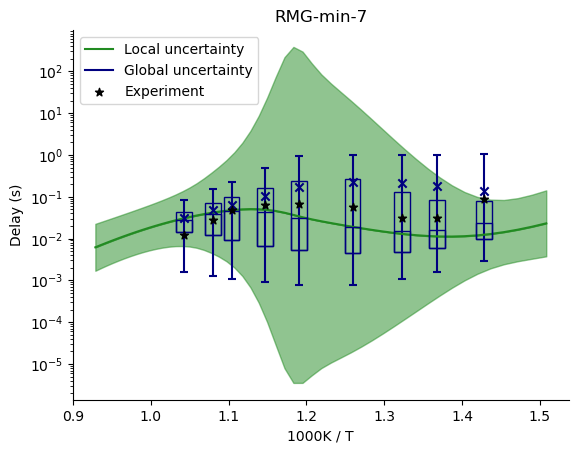

In [107]:
mech_dir = '/home/moon/autoscience/fuels/butane_20240501'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
global_color = mcolors.hex2color(mcolors.CSS4_COLORS['darkgreen'])
global_color = mcolors.hex2color(mcolors.CSS4_COLORS['black'])
global_color = (0.0, 0.29215686274509803, 0.0)
global_color = mcolors.hex2color(mcolors.CSS4_COLORS['navy'])
# global_color = (0.0, 0.0, 0.3019607843137255)
RMG_min_7_color = mcolors.hex2color(mcolors.CSS4_COLORS['forestgreen'])
alpha = 0.5

# Load the analysis files
analysis_dir = os.path.join(mech_dir, 'analysis')
total_uncertainty_mat = np.load(os.path.join(analysis_dir, 'total_uncertainty_mat.npy'))
dft_uncertainty_mat = np.load(os.path.join(analysis_dir, 'dft_uncertainty_mat.npy'))
first_derivative = np.load(os.path.join(analysis_dir, 'first_derivative.npy'))
improvement_score = np.load(os.path.join(analysis_dir, 'improvement_score.npy'))
base_delay_file = os.path.join(mech_dir, 'total_base_delays.npy')
base_delays = np.load(base_delay_file)

delta_uncertainty_squared = np.float_power(total_uncertainty_mat, 2.0) - np.float_power(dft_uncertainty_mat, 2.0)
sensitivity_squared = np.float_power(first_derivative, 2.0)
improvement_score = np.multiply(delta_uncertainty_squared, sensitivity_squared)
avg_improvement_score = np.nanmean(improvement_score, axis=1)
avg_improvement_score[np.isnan(avg_improvement_score)] = -np.inf
improvement_score[np.isnan(improvement_score)] = -np.inf
total_uncertainty_squared = np.nansum(np.multiply(sensitivity_squared, np.float_power(total_uncertainty_mat, 2.0)), axis=0)
total_uncertainty = np.array(np.float_power(total_uncertainty_squared, 0.5)).ravel()

# fetch the Table 7 results
Tmax = 1077  # use min and max temperature range of the data: 663K-1077K
Tmin = 663
K = 51
temperatures = np.linspace(Tmin, Tmax, K)
table_index = 7


base_delays7 = base_delays[(table_index - 1) * K: table_index * K]
total_uncertainty7 = np.array(total_uncertainty[(table_index - 1) * K: table_index * K])

upper_bound_stddev = np.exp(np.log(base_delays7) + total_uncertainty7)
lower_bound_stddev = np.exp(np.log(base_delays7) - total_uncertainty7)

# plot the first mech and uncertainty
plt.plot(1000.0 / temperatures, base_delays7, color=RMG_min_7_color, label='Local uncertainty')


# Local Uncertainty
plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound_stddev, alpha=alpha, color=RMG_min_7_color)
plt.fill_between(1000.0 / temperatures, lower_bound_stddev, base_delays7, alpha=alpha, color=RMG_min_7_color)



# grab all the delay files
Tlist = [700, 731, 756, 794, 840, 872, 906, 926, 959, 1000]
delay_files = glob.glob(os.path.join(mech_dir, 'mc_sampling', 'delays_*.npy'))

M = len(np.load(delay_files[0]))
run_data = np.zeros((len(delay_files) * M, len(Tlist)))
for f in range(len(delay_files)):
    run_data[f * M: (f + 1) * M, :] = np.load(delay_files[f])
run_data[run_data == 0] = np.nan
run_data[run_data < 0] *= -1

tau_list = []
for i in range(len(T7)):
    if int(T7[i]) in Tlist:
        tau_list.append(tau7[i])

ax = plt.gca()
for i in range(len(Tlist[0:-1])):
    
    x = 1000.0 / Tlist[i]
    y = np.nanpercentile(run_data[:, i], 25)
    w = 20 / 1000
    h = np.nanpercentile(run_data[:, i], 75) - np.nanpercentile(run_data[:, i], 25)
    h2 = np.nanpercentile(run_data[:, i], 50) - np.nanpercentile(run_data[:, i], 25)
    
    r = matplotlib.patches.Rectangle((x - w / 2.0, y), width=w, height=h, color=global_color, fill=None, zorder=9)
    r2 = matplotlib.patches.Rectangle((x - w / 2.0, y), width=w, height=h2, color=global_color, fill=None, zorder=9)
    ax.add_patch(r)
    ax.add_patch(r2)
    plt.vlines(x, np.nanpercentile(run_data[:, i], 2.5), np.nanpercentile(run_data[:, i], 97.5), color=global_color)

    plt.scatter(x, np.nanmean(run_data[:, i]), marker='x', color=global_color, zorder=9)
    plt.scatter(x, np.nanpercentile(run_data[:, i], 2.5), marker='_', color=global_color, zorder=9)
    plt.scatter(x, np.nanpercentile(run_data[:, i], 97.5), marker='_', color=global_color, zorder=9)
     

plt.plot(x, y, color=global_color, label='Global uncertainty')
# plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='Experiment', zorder=10)
plt.scatter(1000.0 / np.array(Tlist[:-1]), np.array(tau_list) / 1000.0, color='black', marker='*', label='Experiment', zorder=10)


ax = plt.gca()
ax.set_yscale('log')

plt.title('RMG-min-7')
plt.legend()
plt.xlabel('1000K / T')
plt.ylabel(r'Delay (s)')
plt.legend(loc='upper left')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
    


In [59]:
T7

array([700, 701, 731, 732, 756, 757, 794, 795, 840, 849, 872, 881, 906,
       926, 929, 959])

In [70]:
np.nanmin(run_data[:, 0])

2.446502371000272e-05

/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


(array([  2.,   3.,   1.,   0.,   1.,   0.,   5.,   1.,   1.,   1.,   1.,
          2.,   2.,   2.,   5.,   1.,   2.,   0.,   1.,   2.,  20.,  84.,
        147., 183., 278., 368., 443., 545., 563., 557., 520., 477., 512.,
        466., 429., 383., 287., 251., 226., 176., 154., 134., 124., 107.,
         96.,  85.,  72.,  64.,  64.,  66.]),
 array([-4.61145436e+00, -4.51922522e+00, -4.42699608e+00, -4.33476694e+00,
        -4.24253780e+00, -4.15030866e+00, -4.05807952e+00, -3.96585038e+00,
        -3.87362124e+00, -3.78139210e+00, -3.68916296e+00, -3.59693382e+00,
        -3.50470468e+00, -3.41247554e+00, -3.32024640e+00, -3.22801726e+00,
        -3.13578812e+00, -3.04355898e+00, -2.95132984e+00, -2.85910070e+00,
        -2.76687156e+00, -2.67464242e+00, -2.58241328e+00, -2.49018414e+00,
        -2.39795501e+00, -2.30572587e+00, -2.21349673e+00, -2.12126759e+00,
        -2.02903845e+00, -1.93680931e+00, -1.84458017e+00, -1.75235103e+00,
        -1.66012189e+00, -1.56789275e+00, -1.47566

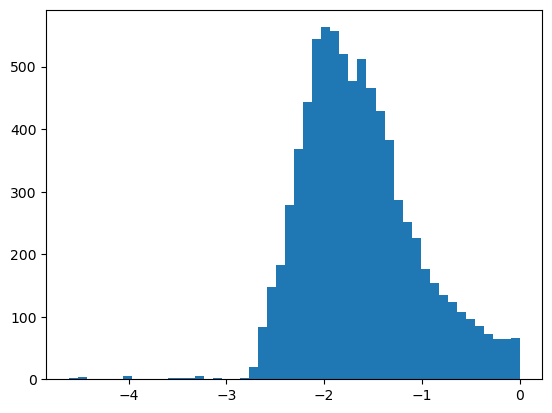

In [26]:
plt.hist(np.log10(run_data[:, 0]), bins=50)

In [15]:
run_data.shape

(9000, 10)

/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


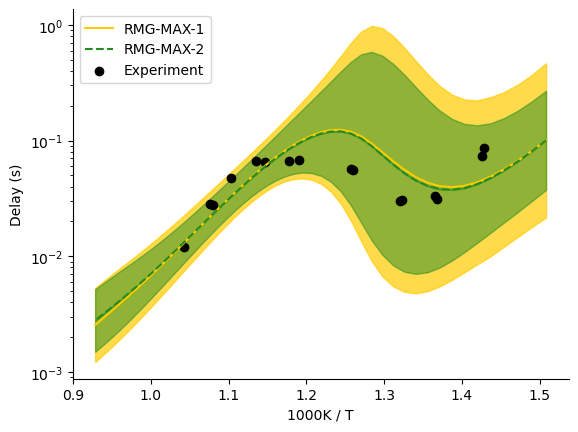

In [11]:
# Repeat for RMG-MAX
mech_dirs = [
    '/home/moon/autoscience/fuels/with_lib/butane_20240401',
    '/home/moon/autoscience/fuels/with_lib/butane_20240413',
]

start_color = (1.0, 0.8, 0.0)
end_color = mcolors.hex2color(mcolors.CSS4_COLORS['forestgreen'])
colors = [start_color, end_color]
labels = ['RMG-MAX-1', 'RMG-MAX-2']
alphas = [0.7, 0.5]
linestyles = ['solid', 'dashed']

for m, mech_dir in enumerate(mech_dirs):
    # Load the analysis files
    analysis_dir = os.path.join(mech_dir, 'analysis')
    total_uncertainty_mat = np.load(os.path.join(analysis_dir, 'total_uncertainty_mat.npy'))
    dft_uncertainty_mat = np.load(os.path.join(analysis_dir, 'dft_uncertainty_mat.npy'))
    first_derivative = np.load(os.path.join(analysis_dir, 'first_derivative.npy'))
    improvement_score = np.load(os.path.join(analysis_dir, 'improvement_score.npy'))
    base_delay_file = os.path.join(mech_dir, 'total_base_delays.npy')
    base_delays = np.load(base_delay_file)
    
    delta_uncertainty_squared = np.float_power(total_uncertainty_mat, 2.0) - np.float_power(dft_uncertainty_mat, 2.0)
    sensitivity_squared = np.float_power(first_derivative, 2.0)
    improvement_score = np.multiply(delta_uncertainty_squared, sensitivity_squared)
    avg_improvement_score = np.nanmean(improvement_score, axis=1)
    avg_improvement_score[np.isnan(avg_improvement_score)] = -np.inf
    improvement_score[np.isnan(improvement_score)] = -np.inf
    total_uncertainty_squared = np.nansum(np.multiply(sensitivity_squared, np.float_power(total_uncertainty_mat, 2.0)), axis=0)
    total_uncertainty = np.array(np.float_power(total_uncertainty_squared, 0.5)).ravel()

    
    # fetch the Table 7 results
    Tmax = 1077  # use min and max temperature range of the data: 663K-1077K
    Tmin = 663
    K = 51
    temperatures = np.linspace(Tmin, Tmax, K)

    table_index = 7


    base_delays7 = base_delays[(table_index - 1) * K: table_index * K]
    total_uncertainty7 = np.array(total_uncertainty[(table_index - 1) * K: table_index * K])

    upper_bound_stddev = np.exp(np.log(base_delays7) + total_uncertainty7)
    lower_bound_stddev = np.exp(np.log(base_delays7) - total_uncertainty7)

    # plot the first mech and uncertainty
    plt.plot(1000.0 / temperatures, base_delays7, color=colors[m], label=labels[m], linestyle=linestyles[m])


    # Local Uncertainty
    plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound_stddev, alpha=alphas[m], color=colors[m])
    plt.fill_between(1000.0 / temperatures, lower_bound_stddev, base_delays7, alpha=alphas[m], color=colors[m])



plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='Experiment')


ax = plt.gca()
ax.set_yscale('log')


plt.legend()
plt.xlabel('1000K / T')
plt.ylabel(r'Delay (s)')
plt.legend(loc='upper left')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
    
